In [1]:
# import time
import torch
# import os
import pandas as pd
import numpy as np
import models
from config import opt
import data
from sklearn import metrics
from tqdm.notebook import tqdm
# import visdom
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
from sklearn.metrics import confusion_matrix

def train_and_evaluate(model_name, model_class, save_model_path=None):
    opt.model = model_name
    opt._parse({})  # Reset the configuration for each model
    adj, features, labels, idx_train, idx_val, idx_test, edges, classes_dict = data.load_data(opt)
    train = data.Dataload(labels, idx_train)
    val = data.Dataload(labels, idx_val)
    test = data.Dataload(labels, idx_test)

    if model_name == 'PyGCN':
        model = getattr(models, opt.model)(features.shape[1], 128, max(labels) + 1).train()
    elif model_name == 'PyGAT':
        model = getattr(models, opt.model)(features.shape[1], 8, max(labels) + 1, dropout=0.6, alpha=0.2, nheads=8).train()
    elif model_name == 'PyGraphsage':
        model = getattr(models, opt.model)(features.shape[1], 8, max(labels) + 1)
    else:
        print("Please input the correct model name: PyGCN, PyGAT or PyGraphsage")
        return
    if opt.load_model_path:
        model.load(opt.load_model_path)

    model = model.to(opt.device)
    adj = adj.to(opt.device)
    features = features.to(opt.device)

    train_dataloader = DataLoader(train, opt.batch_size, shuffle=True, num_workers=opt.num_workers)
    val_dataloader = DataLoader(val, opt.batch_size, shuffle=True, num_workers=opt.num_workers)
    test_dataloader = DataLoader(test, opt.batch_size, shuffle=True, num_workers=opt.num_workers)

    criterion = torch.nn.CrossEntropyLoss()  # Use CrossEntropyLoss
    optimizer = torch.optim.AdamW(model.parameters(), lr=opt.lr, weight_decay=opt.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Example scheduler

    train_losses = []
    val_losses = []
    val_accuracies = []
    confusion_matrices = []

    for name, param in model.named_parameters():
        print(f"Parameter name: {name}, Parameter shape: {param.shape}")
        
    for epoch in range(opt.max_epoch):
        train_loss = 0
        model.train()

        for trains, labels in tqdm(train_dataloader, leave=False):
            labels = labels.to(opt.device)
            trains = trains.to(opt.device)
            optimizer.zero_grad()
            outputs = model(features, adj)
            loss = criterion(outputs[trains], labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_dataloader))

        lr_scheduler.step()  # Adjust learning rate

        val_loss, val_accuracy, labels_all, predict_all, conf_matrix = evaluate(opt, model, val_dataloader, epoch, features, adj)
        val_losses.append(val_loss)  # Store validation loss
        val_accuracies.append(val_accuracy)
        confusion_matrices.append(conf_matrix)

    print(confusion_matrices[-1])  # Print the last confusion matrix

    test_loss, test_accuracy, test_labels_all, test_predict_all, test_conf_matrix = evaluate(opt, model, test_dataloader, epoch, features, adj)
    if save_model_path:
        torch.save(model.state_dict(), save_model_path)

    return train_losses, val_losses, val_accuracies, confusion_matrices, test_loss, test_accuracy, test_labels_all, test_predict_all, test_conf_matrix

def evaluate(opt, model, val_dataloader, epoch, features, adj):
    model.eval()
    loss_total = 0
    predict_all = []
    labels_all = []
    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for evals, labels in tqdm(val_dataloader):
            labels = labels.to(opt.device)
            evals = evals.to(opt.device)
            outputs = model(features, adj)
            loss = criterion(outputs[evals], labels)
            loss_total += loss.item()

            labels = labels.data.cpu().numpy()
            predictions = torch.max(outputs[evals].data, 1)[1].cpu().numpy()

            labels_all.extend(labels)
            predict_all.extend(predictions)

    accuracy = metrics.accuracy_score(labels_all, predict_all)
    print(f"Epoch {epoch}: Validation Loss: {loss_total}, Accuracy: {accuracy}")

    conf_matrix = confusion_matrix(labels_all, predict_all)

    return loss_total, accuracy, labels_all, predict_all, conf_matrix


user config:
model PyGCN
use_gpu False
device cpu
load_model_path None
network cora
batch_size 8
num_workers 3
max_epoch 10
lr 0.005
lr_decay 0.9
weight_decay 1e-05
train_rate 0.8
val_rate 0.1
dropout 0.5
Loading cora dataset...
Parameter name: gc1.weight, Parameter shape: torch.Size([1433, 128])
Parameter name: gc1.bias, Parameter shape: torch.Size([128])
Parameter name: gc2.weight, Parameter shape: torch.Size([128, 7])
Parameter name: gc2.bias, Parameter shape: torch.Size([7])


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 0: Validation Loss: 18.814952462911606, Accuracy: 0.8518518518518519


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1: Validation Loss: 12.701375126838684, Accuracy: 0.8851851851851852


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2: Validation Loss: 10.539434682577848, Accuracy: 0.9


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3: Validation Loss: 9.378190603107214, Accuracy: 0.8962962962962963


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4: Validation Loss: 8.659589983522892, Accuracy: 0.9185185185185185


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5: Validation Loss: 7.6809294214472175, Accuracy: 0.9185185185185185


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6: Validation Loss: 6.776824098080397, Accuracy: 0.9185185185185185


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7: Validation Loss: 6.173920983448625, Accuracy: 0.9185185185185185


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8: Validation Loss: 6.093262294773012, Accuracy: 0.9296296296296296


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9: Validation Loss: 5.479493718594313, Accuracy: 0.937037037037037
[[32  0  0  0  1  0  0]
 [ 1 28  0  0  4  0  0]
 [ 0  1 37  0  1  0  0]
 [ 0  2  0 23  0  0  0]
 [ 3  0  0  0 86  0  0]
 [ 0  1  0  0  1 17  1]
 [ 0  0  0  0  0  1 30]]


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9: Validation Loss: 5.388897946104407, Accuracy: 0.937037037037037
0.937037037037037
user config:
model PyGraphsage
use_gpu False
device cpu
load_model_path None
network cora
batch_size 8
num_workers 3
max_epoch 10
lr 0.005
lr_decay 0.9
weight_decay 1e-05
train_rate 0.8
val_rate 0.1
dropout 0.5
Loading cora dataset...
Parameter name: sage1.W, Parameter shape: torch.Size([2866, 8])
Parameter name: sage1.bias, Parameter shape: torch.Size([8])
Parameter name: sage2.W, Parameter shape: torch.Size([16, 8])
Parameter name: sage2.bias, Parameter shape: torch.Size([8])
Parameter name: att.weight, Parameter shape: torch.Size([7, 8])
Parameter name: att.bias, Parameter shape: torch.Size([7])


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 0: Validation Loss: 24.611119031906128, Accuracy: 0.7703703703703704


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1: Validation Loss: 12.400209695100784, Accuracy: 0.9


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2: Validation Loss: 8.105234962888062, Accuracy: 0.9148148148148149


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3: Validation Loss: 6.139663664624095, Accuracy: 0.9407407407407408


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4: Validation Loss: 4.533499709330499, Accuracy: 0.9592592592592593


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5: Validation Loss: 5.184059095568955, Accuracy: 0.9555555555555556


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6: Validation Loss: 3.318953998037614, Accuracy: 0.9740740740740741


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7: Validation Loss: 2.6790917622856796, Accuracy: 0.9777777777777777


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8: Validation Loss: 2.4740230416646227, Accuracy: 0.9740740740740741


  0%|          | 0/271 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9: Validation Loss: 1.996936150098918, Accuracy: 0.9777777777777777
[[33  0  0  0  0  0  0]
 [ 0 31  0  0  1  1  0]
 [ 0  0 38  0  1  0  0]
 [ 0  0  0 24  0  0  1]
 [ 2  0  0  0 87  0  0]
 [ 0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0 31]]


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9: Validation Loss: 1.9962204673793167, Accuracy: 0.9777777777777777
0.9777777777777777


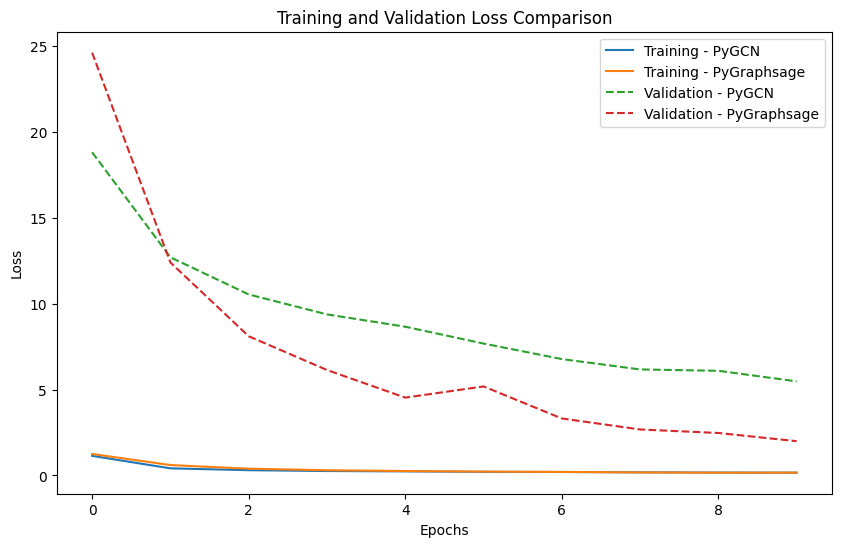

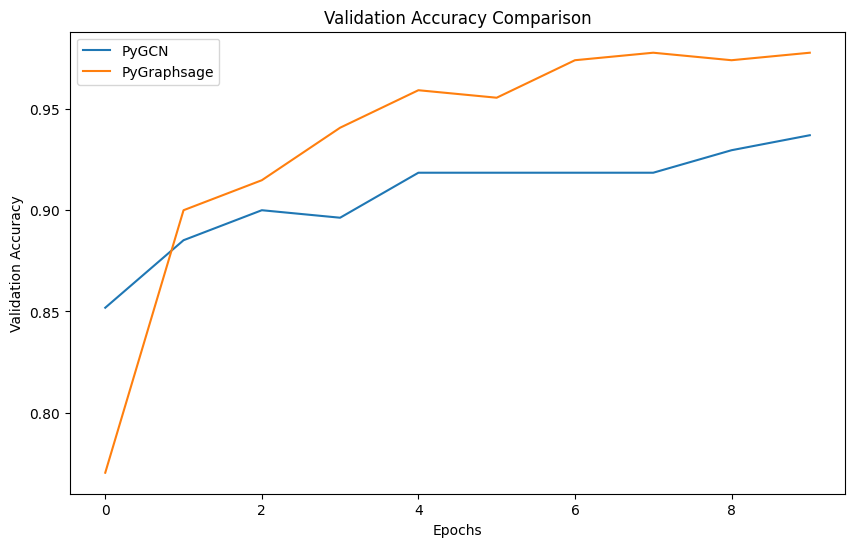

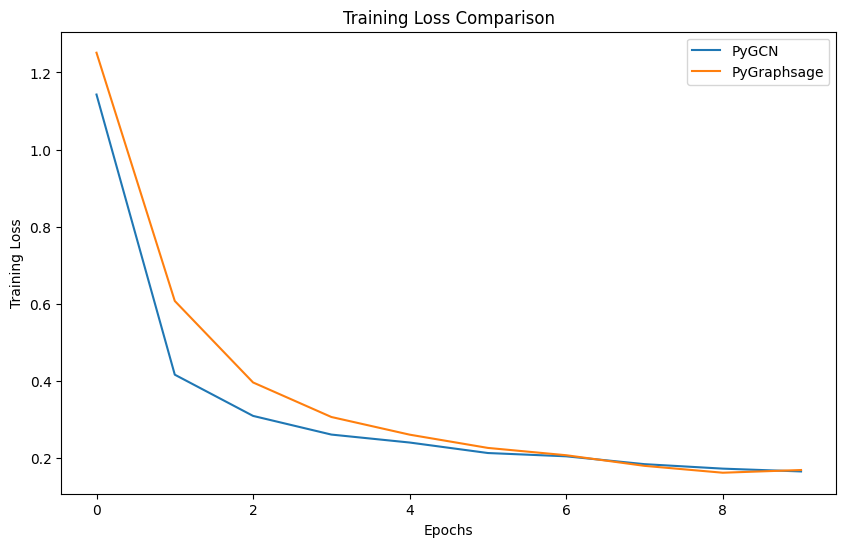

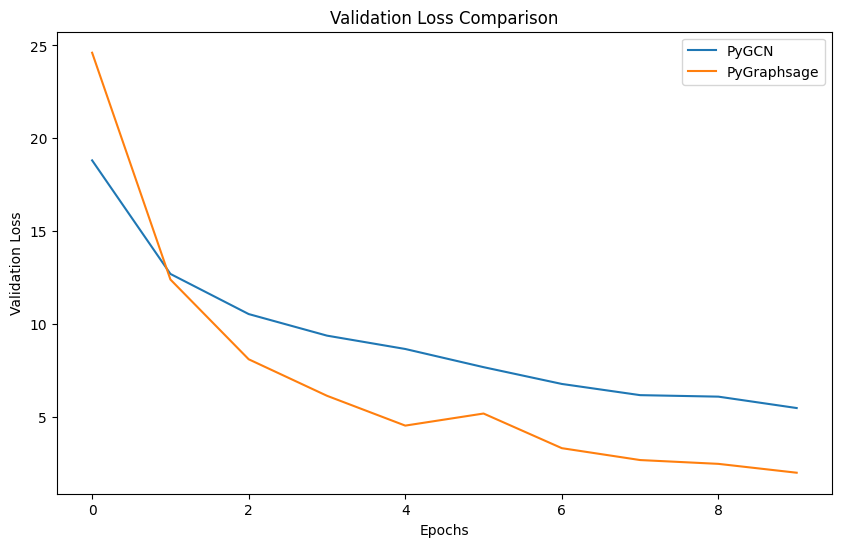

In [4]:
if __name__ == '__main__':
    opt.network = 'cora'  # SELECT HERE THE DATASET YOU WANT
    opt.train_rate = 0.8
    opt.val_rate = 0.1
    opt.max_epoch = 10
    model_names = ['PyGCN', 'PyGraphsage']
    model_classes = [models.PyGCN, models.Graphsage]

    # add the GAT
    # model_names = ['PyGraphsage']
    # model_classes = [models.PyGraphsage]

    train_loss_data = {}
    val_loss_data = {}  # Add this line to store validation losses
    val_accuracy_data = {}

    for model_name, model_class in zip(model_names, model_classes):
        save_path = f"{model_name}_model.pth"  # Specify the path where you want to save the model
        train_losses, val_losses, val_accuracies, conf_matrix,  test_loss, test_accuracy, test_labels_all, test_predict_all, test_conf_matrix = train_and_evaluate(model_name, model_class, save_model_path=save_path)
        train_loss_data[model_name] = train_losses
        val_loss_data[model_name] = val_losses  # Store validation losses
        val_accuracy_data[model_name] = val_accuracies
        print(test_accuracy)

        
     # Create line plots for training and validation losses
    plt.figure(figsize=(10, 6))
    
    # Plot training losses
    for model_name, train_losses in train_loss_data.items():
        plt.plot(train_losses, label=f'Training - {model_name}')
    
    # Plot validation losses
    for model_name, val_losses in val_loss_data.items():
        plt.plot(val_losses, label=f'Validation - {model_name}', linestyle='dashed')
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Comparison")
    plt.legend()
    plt.savefig("combined_loss_plot.png")
    plt.show()

    
    # Create line plots for validation accuracies
    plt.figure(figsize=(10, 6))
    for model_name, val_accuracies in val_accuracy_data.items():
        plt.plot(val_accuracies, label=model_name)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy Comparison")
    plt.legend()
    plt.savefig("plot_val_acc.png")
    plt.show()

    # Create line plots for training losses
    plt.figure(figsize=(10, 6))
    for model_name, train_losses in train_loss_data.items():
        plt.plot(train_losses, label=model_name)
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.savefig("plot.png")
    
    plt.show()

    # Create line plots for validation losses
    plt.figure(figsize=(10, 6))
    for model_name, val_losses in val_loss_data.items():
        plt.plot(val_losses, label=model_name)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss Comparison")
    plt.legend()
    plt.savefig("plot_val_loss.png")
    plt.show()



In [5]:
### Node degree
adj, features, labels, idx_train, idx_val, idx_test, edges,classes_dict = data.load_data(opt)
node_degrees_dict = {}
print("Split", len(idx_train), len(idx_val), len(idx_test))
# Count the out-degrees for each node
for edge in edges:
    for node in edge:
        if node in node_degrees_dict:
            node_degrees_dict[node] += 1
        else:
            node_degrees_dict[node] = 1

# Print or use the dictionary
# print(f"""Node Degrees {opt.network}:""", node_degrees_dict)

Loading cora dataset...
Split 2166 270 270


In [6]:
classes_dict

{'Reinforcement_Learning': 0,
 'Theory': 1,
 'Probabilistic_Methods': 2,
 'Genetic_Algorithms': 3,
 'Neural_Networks': 4,
 'Rule_Learning': 5,
 'Case_Based': 6}

In [7]:
test_conf_matrix

array([[33,  0,  0,  0,  0,  0,  0],
       [ 0, 31,  0,  0,  1,  1,  0],
       [ 0,  0, 38,  0,  1,  0,  0],
       [ 0,  0,  0, 24,  0,  0,  1],
       [ 2,  0,  0,  0, 87,  0,  0],
       [ 0,  0,  0,  0,  0, 20,  0],
       [ 0,  0,  0,  0,  0,  0, 31]])

In [8]:
test_accuracy

0.9777777777777777

In [9]:
train_loss_data

{'PyGCN': [1.1427546338731511,
  0.4152641168682118,
  0.3082086613119968,
  0.25973441795449415,
  0.23907365461612098,
  0.21181227414906575,
  0.20328605954872095,
  0.18289871554653336,
  0.17127505752620564,
  0.16398021254544162],
 'PyGraphsage': [1.2513433360525603,
  0.6066966584687743,
  0.3950565892694401,
  0.30538543241229116,
  0.2595025589466232,
  0.2250656804741735,
  0.2060781541328561,
  0.17850175803669854,
  0.16066206664592714,
  0.16767905868235047]}

In [10]:
val_accuracy_data

{'PyGCN': [0.8518518518518519,
  0.8851851851851852,
  0.9,
  0.8962962962962963,
  0.9185185185185185,
  0.9185185185185185,
  0.9185185185185185,
  0.9185185185185185,
  0.9296296296296296,
  0.937037037037037],
 'PyGraphsage': [0.7703703703703704,
  0.9,
  0.9148148148148149,
  0.9407407407407408,
  0.9592592592592593,
  0.9555555555555556,
  0.9740740740740741,
  0.9777777777777777,
  0.9740740740740741,
  0.9777777777777777]}

In [11]:
# Sum of rows

class_labels = list(classes_dict.keys())
row_sums = np.sum(test_conf_matrix, axis=1)

# Sum of columns
column_sums = np.sum(test_conf_matrix, axis=0)
# Sum total
matrix_sum = np.sum(test_conf_matrix)


# print("Sum of rows:", row_sums/matrix_sum*100)
# print("Sum of columns:", column_sums/matrix_sum*100)

# Convert confusion matrix to percentages
cora_gcn_matrix_percentage = test_conf_matrix.astype('float') / test_conf_matrix.sum(axis=1)[:, np.newaxis] * 100


total_sum = np.sum(test_conf_matrix)

print(len(test_conf_matrix))
print(len(class_labels))
print(row_proportions)
print(class_labels)

# # Proportions
# row_proportions = row_sums / total_sum * 100
# column_proportions = column_sums / total_sum * 100

# # Pie chart for row proportions with actual values
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.pie(row_proportions, labels=class_labels, autopct='%1.1f%%')
# plt.title('Original values')

# # Pie chart for column proportions with predicted values
# plt.subplot(1, 2, 2)
# plt.pie(column_proportions, labels=class_labels, autopct='%1.1f%%')
# plt.title('Predicted values')

# plt.tight_layout()
# plt.show()


7
7


NameError: name 'row_proportions' is not defined

In [ ]:
len(list(classes_dict.keys()))